<a href="https://colab.research.google.com/github/hizhnyack/gamblersTeam_TBank/blob/main/credit_data_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')
plt.rcParams.update({
    'axes.facecolor': 'black',
    'figure.facecolor': '0.1',
    'grid.color': 'yellow',
    'grid.alpha': 0.3,
    'axes.edgecolor': 'yellow',
    'xtick.color': 'yellow',
    'ytick.color': 'yellow',
    'axes.labelcolor': 'yellow',
    'text.color': 'yellow'
})

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/merget_dataset.v3.csv', sep=',', parse_dates=['expiration_minus_1d_dt'], index_col=['key']).drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'])

In [ ]:
credit_data = pd.read_csv('/content/drive/MyDrive/credit_history_fixed.csv')
credit_data.index += 1

In [ ]:
data.drop(columns=['expiration_minus_1d_dt'], inplace=True)

In [ ]:
data = data.join(credit_data, how='inner')

In [ ]:
data.head()

,target_x,Poluchaet_ZP_x,Oplata_SBP_po_QR_x,Internet_x,Ishodjaschij_SBP_perevod_x,Poluchil_vhodjaschij_SBP_x,credit_class_x,avg_hl_delay_log,cred_av_log,delay_m4_cnt_category,sovokupnye_traty,avg_integral_cur_rur_balance,avg_out_puc,months_cnt,Deneg_bolee_100tys,Traty_bolee_10tys,IFL,Strahovanie_ipoteki,Oteli,Kasko,Karshering,VZR,Travel,Oplatil_toplivo_v_Tinkoff_Gorod,Oplatil_shtraf,Avtoplatezh,LifeStyle,Dopka_na_3_litso,Osago,Privel_druga,used_special_offer,ZhKH,Poluchil_mezhbankovskij_perevod,Podpiski_na_servisy,Junior,Est'_mobajl,Investkopilka,Taksi,NS_keptivnaja_strahovka,Popolnil_v_bankomate,Zapravki,Podpiska_na_shtrafy,Perevod_po_telefonu_karte_so_sbera,Dostavka_edy,Odezhda_elektronika,Ecom,Obschestvennyj_transport,Mobil'naja_svjaz',Kafe_restorany_fastfud,Onlajn_tranzaktsija,Supermarket,party_rk_count,time_since_utilization_brk,time_since_opened_mob,accnt_auto_cnt,accnt_cnt,max_out_tel_mbk_cnt,mpl_std_time,avg_total_cur_balance,avg_out_request_cnt,ipl_perc,log_p_q_av,3+_aktivnyh_produkta,Sovmestnyj_schet,IIS,Premium,Sharing_scheta,Kubyshka,Popolnjal_brokerskij,Biznes_schet,Pro,Nakopitel'nyj_schet,Brokerskij_schet,Kreditnyj_produkt,count_of_open_brk,count_of_ever_opened_ccr,count_of_all_open,median_count_of_ever_opened_cor,avg_count_of_utils_lon,insurance,traveller,investor,t-gorod,life_exp,credit_class_y,Unnamed: 0,hl_delay_log,outst_rate,expiration_minus_1d_dt,id,target,delay_m4_cnt_category_one_hot,avg_delay_m4_cnt_category_one_hot
2,0,0,0,0,0,0,2,0.775721,0.136405,1,0,4,6,0.961442,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,-0.029440,1.418378,-0.110477,-0.29,-0.298840,-0.670751,0.405554,-0.003254,1.513621,-0.018704,-1.061606,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,-0.628947,0.363142,-1.086701,-0.084553,-0.374220,1,0,0,0,0,2,1,4.09434,0.85,2024-05-26,302422,0,1.0,1.0
3,0,0,0,0,1,1,2,0.627673,0.258929,1,0,3,4,-0.298232,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-0.014174,1.010083,-0.110477,-0.29,-0.440837,0.973741,0.336594,-0.128016,-0.607214,-0.268253,-0.095477,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.628947,0.363142,-0.440391,-0.039904,0.783685,0,0,0,0,1,2,2,4.09434,0.85,2024-02-22,325078,0,1.0,2.0
4,0,0,1,0,1,1,2,0.517147,0.463380,1,6,3,5,3.480789,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,-0.034529,-0.753403,-0.110477,-0.29,-0.582835,-0.579390,-0.266148,0.034740,0.056541,-0.268253,1.459461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.628947,-0.799068,-1.086701,-0.062228,-0.502876,0,0,0,0,2,2,3,4.09434,0.85,2024-01-15,284248,0,3.0,2.0
5,1,0,1,0,1,1,0,0.454584,0.136405,3,6,4,4,-0.298232,1,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0.021448,0.843290,-0.110477,-0.29,1.973116,-0.579390,4.312287,-0.091333,0.641893,-0.268253,0.172598,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,-0.628947,1.525351,0.205919,-0.270593,-0.502876,1,1,0,0,3,0,4,0.00000,0.60,2024-02-24,151409,1,1.0,2.0
6,0,0,0,0,1,1,2,0.497944,0.549869,1,4,1,3,0.961442,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0.016359,-0.753403,-0.110477,-0.29,-0.014846,-0.670751,0.399805,-0.214959,0.078879,-0.268253,-0.472779,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,-0.628947,0.363142,-1.086701,-0.278035,-0.502876,1,1,0,0,1,2,5,4.09434,0.85,2024-05-17,23822,0,1.0,2.0


In [ ]:
data['target_x'].describe().T

,target_x
count,593432.000000
mean,0.202610
std,0.401944
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Все данные разделим по категориям, далее будем рассматривать их по отдельности, чтобы выявить закономерности

In [ ]:
from collections import defaultdict
def categorize_features(df_columns):
    categories = {
        'Идентификаторы и временные метки': ['id', 'dt', 'date', 'target'],
        'Финансовые показатели': ['balans', 'income', 'amt', 'sum', 'debt', 'outstnd', 'credit', 'turnover', 'curr_balance'],
        'Характеристики вкладов конкурентов': ['tarif', 'month_cnt', 'renewal', 'diff_'],
        'Кэшбэк и бонусы': ['cashback', 'loyalty', 'bonus', 'accrual'],
        'Продуктовая активность': ['produkt', 'schet', 'vklad', 'iis', 'premium', 'private', 'pro', 'kubyshka', 'broker', 'nakopitel', 'kredit', 'card', 'dk'],
        'Социально-демографические данные': ['age', 'gender', 'education', 'marital', 'risk', 'longitude', 'time_zone'],
        'Поведенческие паттерны': ['category', 'traffic', 'online', 'sbp', 'autoplatezh', 'zp', 'friend', 'food', 'taxi', 'internet', 'mobile'],
        'Кредитная история': ['delay', 'cred', 'outst', 'hl_', 'time_since_utilization_brk', 'days_cred_use_sum', 'accnt_rev_cnt', 'accnt_cnt', 'out_request_cnt_sum', 'out_request_cnt_3', 'cur_delqbalance_max', 'wrst_delqbalance_max'],
        'Внешние факторы': ['diff_', 'competitor', 'rate'],
        'Технические метрики': ['days_from', 'count_of', 'full_time', 'auth']
    }
    feature_groups = defaultdict(list)

    for column in df_columns:
        column_lower = column.lower()
        categorized = False

        for category, keywords in categories.items():
            if any(keyword in column_lower for keyword in keywords):
                feature_groups[category].append(column)
                categorized = True
                break

        if not categorized:
            feature_groups['Другие'].append(column)

    return dict(feature_groups)

cat_data = categorize_features(data)

In [ ]:
data.head()

,Unnamed: 0_x,target_x,expiration_minus_1d_dt,Poluchaet_ZP_x,Oplata_SBP_po_QR_x,Internet_x,Ishodjaschij_SBP_perevod_x,Poluchil_vhodjaschij_SBP_x,credit_class_x,avg_hl_delay_log,cred_av_log,delay_m4_cnt_category,sovokupnye_traty,avg_integral_cur_rur_balance,avg_out_puc,months_cnt,Deneg_bolee_100tys,Traty_bolee_10tys,IFL,Strahovanie_ipoteki,Oteli,Kasko,Karshering,VZR,Travel,Oplatil_toplivo_v_Tinkoff_Gorod,Oplatil_shtraf,Avtoplatezh,LifeStyle,Dopka_na_3_litso,Osago,Privel_druga,used_special_offer,ZhKH,Poluchil_mezhbankovskij_perevod,Podpiski_na_servisy,Junior,Est'_mobajl,Investkopilka,Taksi,NS_keptivnaja_strahovka,Popolnil_v_bankomate,Zapravki,Podpiska_na_shtrafy,Perevod_po_telefonu_karte_so_sbera,Dostavka_edy,Odezhda_elektronika,Ecom,Obschestvennyj_transport,Mobil'naja_svjaz',Kafe_restorany_fastfud,Onlajn_tranzaktsija,Supermarket,party_rk_count,time_since_utilization_brk,time_since_opened_mob,accnt_auto_cnt,accnt_cnt,max_out_tel_mbk_cnt,mpl_std_time,avg_total_cur_balance,avg_out_request_cnt,ipl_perc,log_p_q_av,3+_aktivnyh_produkta,Sovmestnyj_schet,IIS,Premium,Sharing_scheta,Kubyshka,Popolnjal_brokerskij,Biznes_schet,Pro,Nakopitel'nyj_schet,Brokerskij_schet,Kreditnyj_produkt,count_of_open_brk,count_of_ever_opened_ccr,count_of_all_open,median_count_of_ever_opened_cor,avg_count_of_utils_lon,Unnamed: 0_y,insurance,traveller,investor,t-gorod,life_exp,credit_class_y
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0,0,2024-05-26,0,0,0,0,0,2,0.775721,0.136405,1,0,4,6,0.961442,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,-0.029440,1.418378,-0.110477,-0.29,-0.298840,-0.670751,0.405554,-0.003254,1.513621,-0.018704,-1.061606,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,-0.628947,0.363142,-1.086701,-0.084553,-0.374220,1,1,0,0,0,0,2
3,1,0,2024-02-22,0,0,0,1,1,2,0.627673,0.258929,1,0,3,4,-0.298232,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-0.014174,1.010083,-0.110477,-0.29,-0.440837,0.973741,0.336594,-0.128016,-0.607214,-0.268253,-0.095477,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.628947,0.363142,-0.440391,-0.039904,0.783685,2,0,0,0,0,1,2
4,2,0,2024-01-15,0,1,0,1,1,2,0.517147,0.463380,1,6,3,5,3.480789,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,-0.034529,-0.753403,-0.110477,-0.29,-0.582835,-0.579390,-0.266148,0.034740,0.056541,-0.268253,1.459461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.628947,-0.799068,-1.086701,-0.062228,-0.502876,3,0,0,0,0,2,2
5,3,1,2024-02-24,0,1,0,1,1,0,0.454584,0.136405,3,6,4,4,-0.298232,1,1,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0.021448,0.843290,-0.110477,-0.29,1.973116,-0.579390,4.312287,-0.091333,0.641893,-0.268253,0.172598,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,-0.628947,1.525351,0.205919,-0.270593,-0.502876,4,1,1,0,0,3,0
6,4,0,2024-05-17,0,0,0,1,1,2,0.497944,0.549869,1,4,1,3,0.961442,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0.016359,-0.753403,-0.110477,-0.29,-0.014846,-0.670751,0.399805,-0.214959,0.078879,-0.268253,-0.472779,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,-0.628947,0.363142,-1.086701,-0.278035,-0.502876,5,1,1,0,0,1,2


In [ ]:
columns_for_segmentations = ['Poluchaet_ZP_x', 'delay_m4_cnt_category', 'sovokupnye_traty', 'avg_integral_cur_rur_balance', 'months_cnt', '']

In [ ]:
social_features_cols = cat_data['Социально-демографические данные']
tech_features_cols = cat_data['Технические метрики']
credit_features_cols = cat_data['Кредитная история']
product_features_cols = cat_data['Продуктовая активность']
behav_features_cols = cat_data['Поведенческие паттерны']
diff_features_cols = cat_data['Характеристики вкладов конкурентов']
others_features_cols = cat_data['Другие']
finance_features_cols = cat_data['Финансовые показатели']
time_features_cols = cat_data['Идентификаторы и временные метки']

In [ ]:
credit_data = data[credit_features_cols + ['target']]

In [ ]:
credit_data.describe().T

,count,mean,std,min,25%,50%,75%,max
time_since_utilization_brk,593014.0,433.938297,5.756531e+02,0.00000,0.000000,0.000000,935.000000,2.384000e+03
delay_m4_cnt,428438.0,0.980739,7.885672e+00,0.00000,0.000000,0.000000,0.000000,2.110000e+02
zkr_open_accnt_cnt,552669.0,0.848667,1.472531e+00,0.00000,0.000000,0.000000,1.000000,4.100000e+01
accnt_rev_cnt,552700.0,1.737147,2.754779e+00,0.00000,0.000000,1.000000,2.000000,1.240000e+02
accnt_cnt,552707.0,4.259622,7.273194e+00,0.00000,1.000000,2.000000,6.000000,8.770000e+02
out_request_cnt_3,480519.0,10.633559,2.488043e+01,0.00000,3.000000,5.000000,10.000000,7.660000e+02
avg_out_request_cnt_3,580928.0,15.515201,1.943578e+01,0.00000,5.600000,9.350000,17.333333,8.345000e+02
avg_delay_m4_cnt,573194.0,4.350846,1.006886e+01,0.00000,0.000000,0.000000,3.600000,2.120000e+02
avg_hl_delay_log,587324.0,3.300252,8.361297e-01,0.00000,2.756243,3.492618,4.094340,5.278110e+00
cur_delqbalance_max,425073.0,26510.033158,1.506538e+07,0.00000,0.000000,0.000000,0.000000,9.821674e+09


In [ ]:
credit_data.head()

,time_since_utilization_brk,delay_m4_cnt,zkr_open_accnt_cnt,accnt_rev_cnt,accnt_cnt,out_request_cnt_3,avg_out_request_cnt_3,avg_delay_m4_cnt,avg_hl_delay_log,cur_delqbalance_max,cred_av_log,hl_delay_log,outst_rate,wrst_delqbalance_max,target
key,,,,,,,,,,,,,,,
1,1048.0,0.0,0.0,1.0,1.0,NaN,3.750000,0.000000,4.094340,0.0,9.61581,4.09434,0.85,0.0,0
2,1250.0,0.0,0.0,2.0,2.0,5.0,47.428571,0.000000,3.312928,0.0,11.22524,4.09434,0.85,0.0,0
3,1015.0,0.0,0.0,0.0,1.0,1.0,4.074074,6.000000,2.729560,0.0,13.91082,4.09434,0.85,0.0,0
4,0.0,NaN,0.0,0.0,0.0,2.0,8.312500,5.333333,2.399344,NaN,9.61581,4.09434,0.85,NaN,0
5,919.0,0.0,3.0,5.0,18.0,15.0,8.750000,1.666667,2.628202,0.0,15.04691,0.00000,0.60,97991.0,1


Оценим количество пропусков и для каждого признака посмотрим, что лучше с этими пропусками сделать, чтобы не изменить общие показатели

In [ ]:
credit_data.isna().sum() / credit_data.shape[0] * 100

,0
time_since_utilization_brk,0.070606
delay_m4_cnt,27.803476
zkr_open_accnt_cnt,6.869183
accnt_rev_cnt,6.863959
accnt_cnt,6.862780
out_request_cnt_3,19.027253
avg_out_request_cnt_3,2.107230
avg_delay_m4_cnt,3.410495
avg_hl_delay_log,1.029434
cur_delqbalance_max,28.370515


Далее рассмотрим корреляцию между отдельными признаками и некатегориальными признаками и таргетом. Избавимся от мультиколлинеарности и оценим показатели, по которым можно объеденить пользователей, чтобы уже из описания каждого кластера пользователей предложить оптимальные действия, которые могут повлиять на то, оставит ли человек вклад в Т банке

<Axes: >

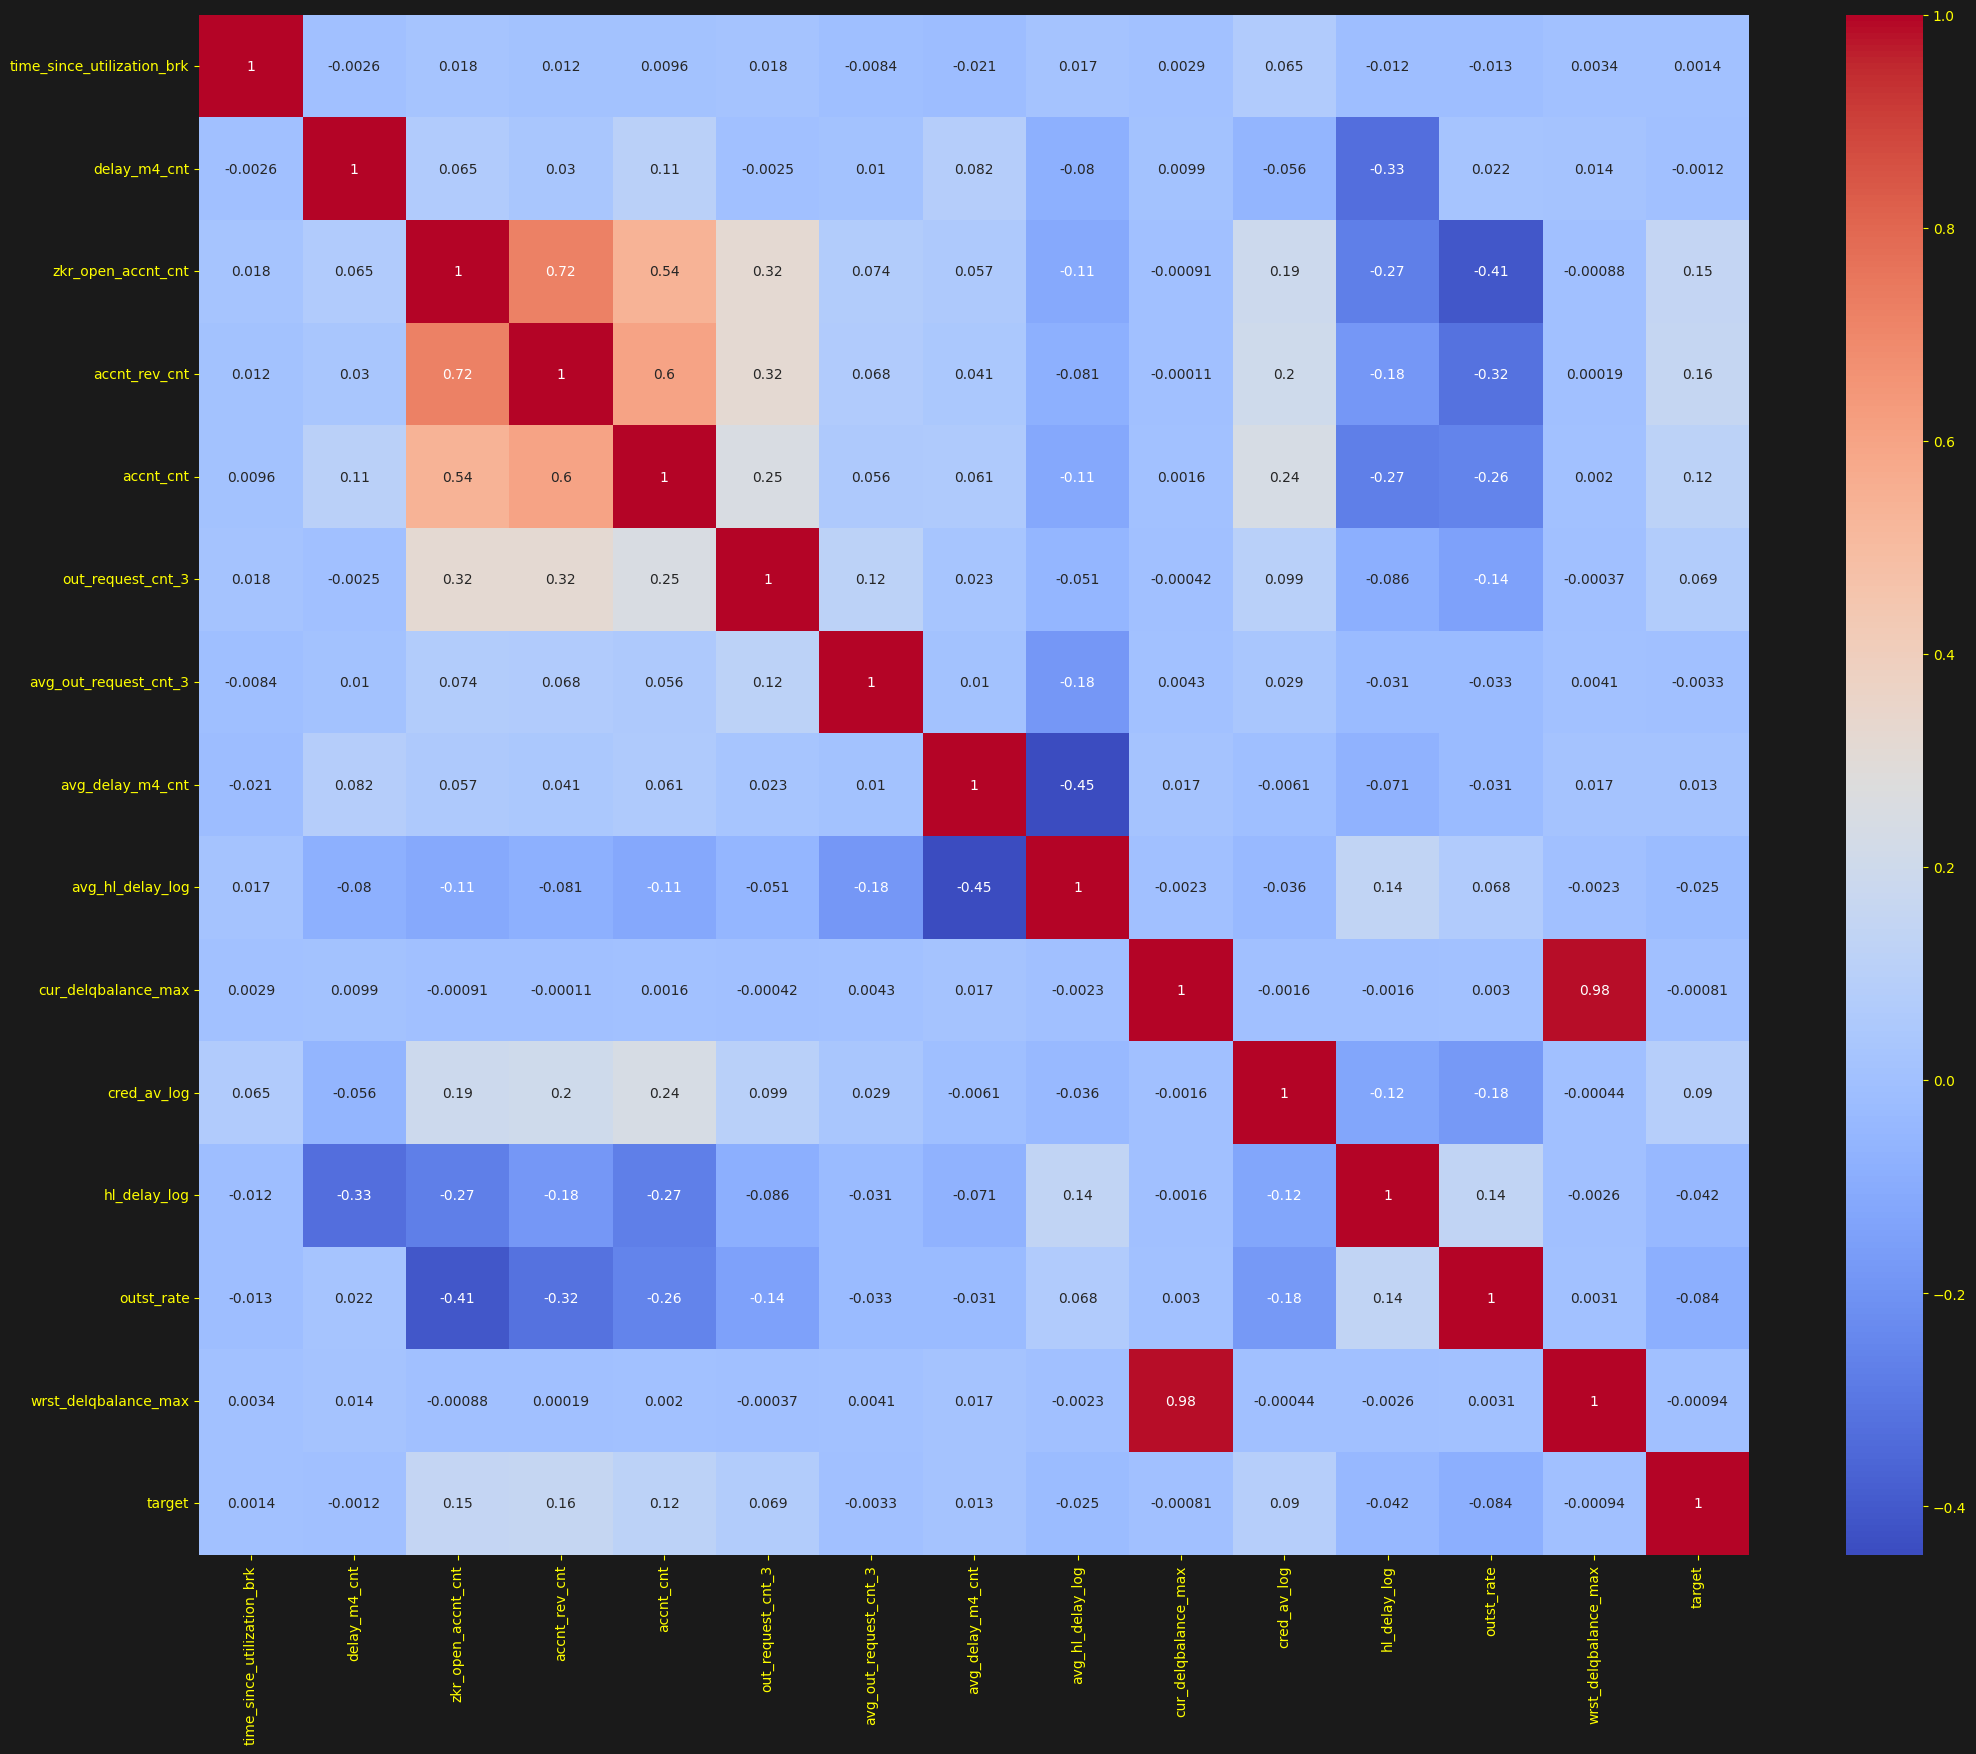

In [ ]:
plt.figure(figsize=(25, 20))
corr_matrix = credit_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

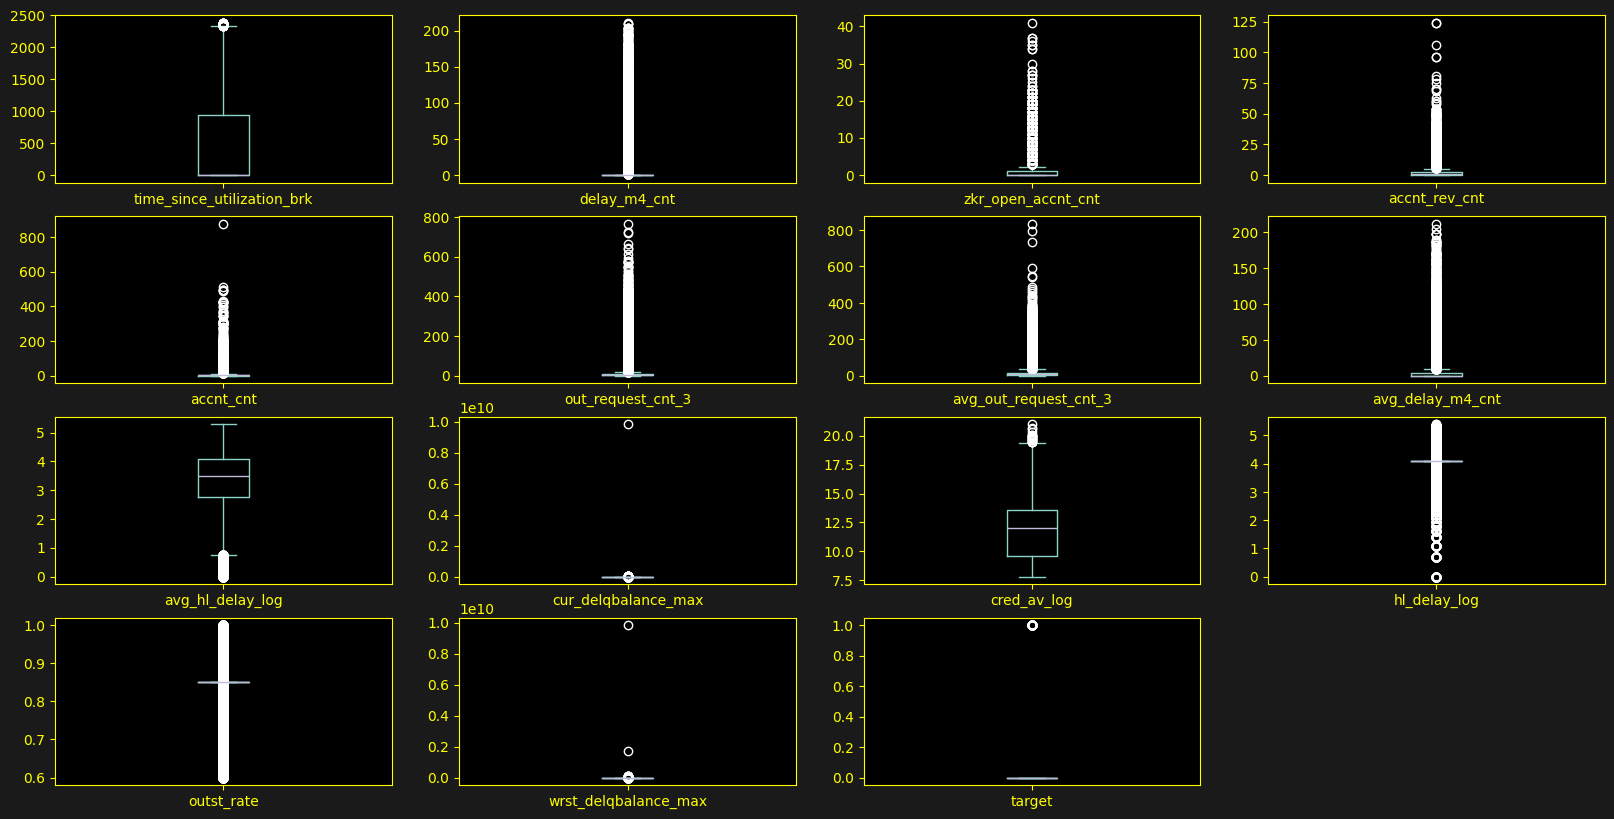

In [ ]:
plt.figure(figsize=(20, 10))
for i, col in enumerate(credit_data.columns):
  plt.subplot(4, 4, i+1)
  credit_data[col].plot(kind='box')

In [ ]:
#delete multycollinearnost'
credit_data = credit_data.drop(columns=['accnt_rev_cnt', 'accnt_cnt', 'cur_delqbalance_max'])

Пойдем от обратного и сначала оценим кредитные показетели среди таргета 0 (продливших и пополнивших вклад) и 1 (тех, кто снял деньги с вклада и в течении 14 дней перевел более 75% от этих денег в другой банк)

In [ ]:
loyal = credit_data[credit_data['target'] == 0]
churned = credit_data[credit_data['target'] == 1]

loyal.describe().T

,count,mean,std,min,25%,50%,75%,max
time_since_utilization_brk,472794.0,433.542067,5.759784e+02,0.00000,0.000000,0.000000,936.000000,2.384000e+03
delay_m4_cnt,331641.0,0.985665,7.895328e+00,0.00000,0.000000,0.000000,0.000000,2.110000e+02
zkr_open_accnt_cnt,438941.0,0.736447,1.319924e+00,0.00000,0.000000,0.000000,1.000000,3.700000e+01
out_request_cnt_3,376434.0,9.734525,2.285701e+01,0.00000,2.000000,5.000000,9.000000,7.660000e+02
avg_out_request_cnt_3,462994.0,15.547126,1.927165e+01,0.00000,5.529412,9.388889,17.611111,8.345000e+02
avg_delay_m4_cnt,456543.0,4.286479,9.987884e+00,0.00000,0.000000,0.000000,3.500000,2.120000e+02
avg_hl_delay_log,468238.0,3.310952,8.297372e-01,0.00000,2.779089,3.506549,4.094340,5.278110e+00
cred_av_log,438941.0,11.828842,1.962034e+00,7.82405,9.615810,11.838630,13.480390,2.095965e+01
hl_delay_log,438941.0,3.913091,6.492680e-01,0.00000,4.094340,4.094340,4.094340,5.384500e+00
outst_rate,438941.0,0.810549,9.803928e-02,0.60000,0.850000,0.850000,0.850000,1.000000e+00


In [ ]:
churned.describe().T

,count,mean,std,min,25%,50%,75%,max
time_since_utilization_brk,120220.0,435.496565,574.371406,0.00000,0.00000,0.000000,930.000000,2.380000e+03
delay_m4_cnt,96797.0,0.963863,7.852516,0.00000,0.00000,0.000000,0.000000,1.980000e+02
zkr_open_accnt_cnt,113728.0,1.281786,1.891275,0.00000,0.00000,1.000000,2.000000,4.100000e+01
out_request_cnt_3,104085.0,13.885007,30.901261,0.00000,4.00000,7.000000,12.000000,7.220000e+02
avg_out_request_cnt_3,117934.0,15.389865,20.066728,0.00000,5.75000,9.333333,16.250000,7.315000e+02
avg_delay_m4_cnt,116651.0,4.602762,10.375907,0.00000,0.00000,0.000000,4.149074,1.970000e+02
avg_hl_delay_log,119086.0,3.258179,0.859518,0.00000,2.72956,3.431523,4.094340,5.209490e+00
cred_av_log,113728.0,12.264031,1.841488,7.82405,10.71442,12.485790,13.708770,2.056519e+01
hl_delay_log,113728.0,3.842836,0.742810,0.00000,4.09434,4.094340,4.094340,5.370640e+00
outst_rate,113728.0,0.789224,0.116467,0.60000,0.65622,0.850000,0.850000,1.000000e+00


In [ ]:
#в основном пропуски в числовых данных будут иметь пользователи с отсутствием кредитной истории,
#то есть разделяя людей на категории по кредитным задолжностям, мы приравниваем их к добросовестным платильщикам
#(к тем, у кого в этих колонках 0), поэтому объединим их, заполнив нулями, не потеряв данные
credit_data = credit_data.fillna(0)

Нормализируем числовые показатели, поскольку в дальнейшем нам пригодится именно такой формат

In [ ]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_clast = ss.fit_transform(credit_data.drop(columns=['target', 'time_since_utilization_brk', 'wrst_delqbalance_max']))

Далее для проведения аналеза не отдельных кредитных признаков, а групп людей, объединенных близкими показателями по кредитам, проведем кластеризацию. Определять количество кластеров будем методом "локтя", хотя изничально понятно, что по итогу будет выделено 2-3 группы.

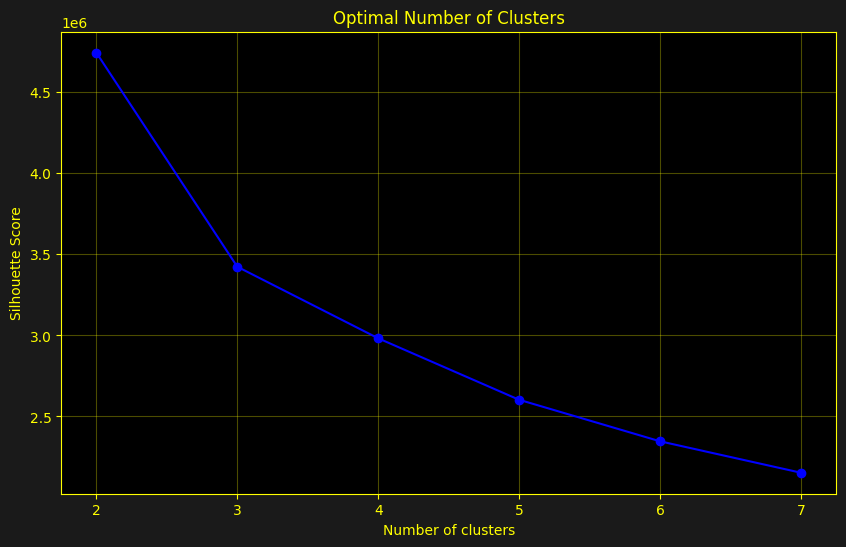

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

scores = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_clast)
    score = kmeans.inertia_
    scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 8), scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Optimal Number of Clusters')
plt.grid(True)
plt.show()

In [ ]:
best_k = 3
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_clast)

credit_data['cluster'] = clusters

In [ ]:
credit_data['cluster'].value_counts()

,count
cluster,
0,411404
1,141221
2,40808


После понижения размерности на 2д проекции посмотрим на различие сегментов, далее оценим показатели и разницу оттока

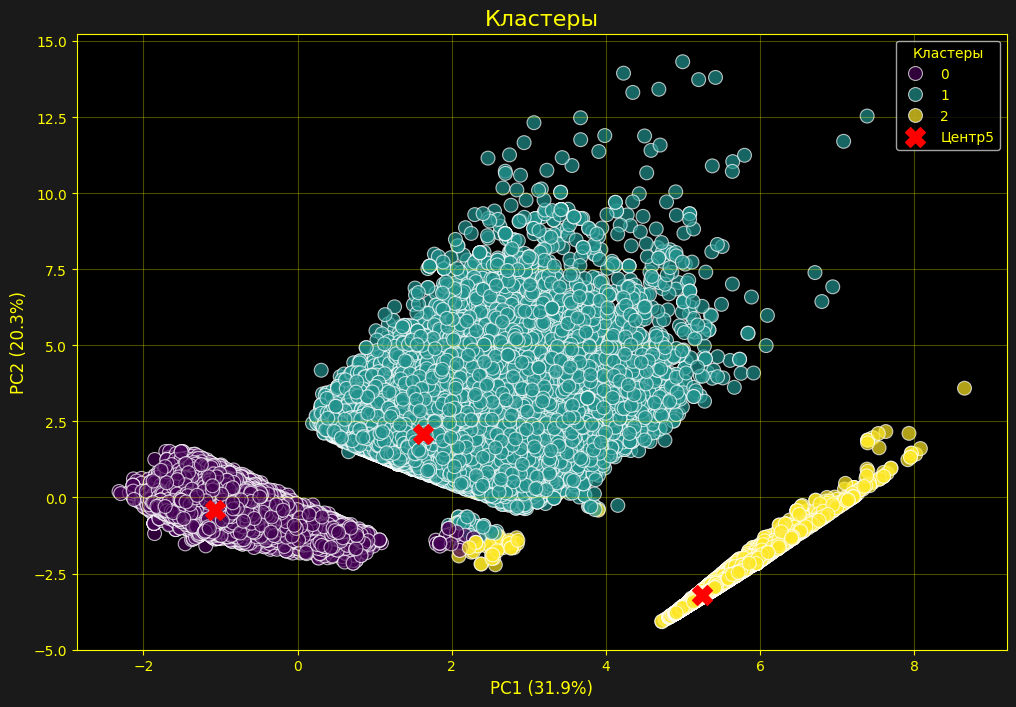

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clast)

viz_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster': clusters
})

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=viz_df,
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette='viridis',
    alpha=0.7,
    s=100
)

centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker='X',
    s=200,
    c='red',
    label='Центр5'
)

plt.title('Кластеры', fontsize=16)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
plt.legend(title='Кластеры')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
class1 = credit_data[credit_data['cluster'] == 0]
class2 = credit_data[credit_data['cluster'] == 1]
class3 = credit_data[credit_data['cluster'] == 2]

In [ ]:
class1.describe().T

,count,mean,std,min,25%,50%,75%,max
time_since_utilization_brk,411404.0,453.174354,585.355301,0.00000,0.000000,0.000000,975.000000,2.384000e+03
delay_m4_cnt,411404.0,0.121399,1.667078,0.00000,0.000000,0.000000,0.000000,7.900000e+01
zkr_open_accnt_cnt,411404.0,0.478590,0.838547,0.00000,0.000000,0.000000,1.000000,6.000000e+00
out_request_cnt_3,411404.0,5.341871,8.376860,0.00000,1.000000,4.000000,7.000000,1.460000e+02
avg_out_request_cnt_3,411404.0,12.254331,12.566463,0.00000,5.000000,8.333333,14.444444,1.460000e+02
avg_delay_m4_cnt,411404.0,1.307678,3.426446,0.00000,0.000000,0.000000,0.333333,3.833333e+01
avg_hl_delay_log,411404.0,3.587152,0.572655,1.09861,3.189284,3.790936,4.094340,5.278110e+00
cred_av_log,411404.0,11.795987,2.032571,7.82405,9.615810,11.695250,13.589892,2.095965e+01
hl_delay_log,411404.0,4.001315,0.426775,0.00000,4.094340,4.094340,4.094340,5.384500e+00
outst_rate,411404.0,0.819809,0.088160,0.60000,0.850000,0.850000,0.850000,1.000000e+00


In [ ]:
class2.describe().T

,count,mean,std,min,25%,50%,75%,max
time_since_utilization_brk,141221.0,433.907415,5.704610e+02,0.00000,0.000000,0.000000,922.00000,2.375000e+03
delay_m4_cnt,141221.0,2.619426,1.328634e+01,0.00000,0.000000,0.000000,0.00000,2.110000e+02
zkr_open_accnt_cnt,141221.0,1.926789,2.208146e+00,0.00000,0.000000,1.000000,3.00000,4.100000e+01
out_request_cnt_3,141221.0,20.618662,4.217100e+01,0.00000,4.000000,8.000000,15.00000,7.660000e+02
avg_out_request_cnt_3,141221.0,24.047641,2.980744e+01,0.00000,7.500000,13.333333,29.00000,8.345000e+02
avg_delay_m4_cnt,141221.0,12.823091,1.594703e+01,0.00000,0.000000,7.875000,19.75000,2.120000e+02
avg_hl_delay_log,141221.0,2.332201,9.618533e-01,0.00000,1.826877,2.393750,2.96061,4.795790e+00
cred_av_log,141221.0,12.275856,1.614874e+00,7.82405,11.247480,12.429220,13.44167,2.030015e+01
hl_delay_log,141221.0,3.600721,1.050218e+00,0.00000,3.806660,4.094340,4.09434,5.370640e+00
outst_rate,141221.0,0.766427,1.277484e-01,0.60000,0.600000,0.850000,0.85000,1.000000e+00


In [ ]:
class3.describe().T

,count,mean,std,min,25%,50%,75%,max
time_since_utilization_brk,40808.0,235.662223,440.349875,0.0,0.00000,0.000000,245.000000,2322.00000
delay_m4_cnt,40808.0,0.007940,0.396996,0.0,0.00000,0.000000,0.000000,34.00000
zkr_open_accnt_cnt,40808.0,0.000858,0.036029,0.0,0.00000,0.000000,0.000000,3.00000
out_request_cnt_3,40808.0,0.004215,0.161874,0.0,0.00000,0.000000,0.000000,13.00000
avg_out_request_cnt_3,40808.0,14.107574,20.577848,0.0,4.25000,8.000000,15.346939,545.00000
avg_delay_m4_cnt,40808.0,3.553347,9.622586,0.0,0.00000,0.000000,1.333333,161.00000
avg_hl_delay_log,40808.0,3.263881,1.053839,0.0,2.75468,3.646734,4.094340,5.20949
cred_av_log,40808.0,0.009864,0.301339,0.0,0.00000,0.000000,0.000000,10.39472
hl_delay_log,40808.0,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.00000
outst_rate,40808.0,0.000777,0.024004,0.0,0.00000,0.000000,0.000000,0.85000


In [ ]:
credit_data.rename(columns={'cluster': 'credit_class'}, inplace=True)

Так как размер групп сильно отличается, изничально оценить влияние фактора на таргет нужно статистически. Мы используем категориальный признак и бинарный результат, поэтому проверим воздействие при помощи Хи^2

In [ ]:
from sklearn.feature_selection import chi2
import numpy as np

chi2, p_val = chi2(credit_data['credit_class'].to_numpy().reshape(-1, 1), credit_data['target'].to_numpy().reshape(-1, 1))
display(f'chi2: {float(chi2)}, p_val: {float(p_val)}')

<ipython-input-36-9cbf24f88fb8>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  display(f'chi2: {float(chi2)}, p_val: {float(p_val)}')


'chi2: 1379.8677361366845, p_val: 4.980069263717915e-302'

In [ ]:
#крайне низкий уровень p-value - признак значимости
class2_3 = credit_data[credit_data['credit_class'].isin([1, 2])]

In [ ]:
class2_3['target'].describe().T

,target
count,452246.000000
mean,0.185331
std,0.388566
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [ ]:
data['credit_class'] = credit_data['credit_class']

In [ ]:
data.groupby(by=['credit_class']).agg({'age': 'median', 'days_cred_use_sum': 'median', 'avg_education_level': 'mean'})

,age,days_cred_use_sum,avg_education_level
credit_class,,,
0,40.0,6443.0,3.240302
1,45.0,NaN,3.378644
2,39.0,4241.0,3.445871


По итого у классов следующая интерпритация:
класс 0 (400 000 наблюдений) - основная группа пользователей, имеют опыт взаимодействия с кредитным продуктом, являются хорошими платильщиками, практически нет задержек в оплатых. Уровень оттока - 18%, в это время средний - 21%,
класс 1 (140 000) - самая "опасная" группа, имеют самыю плохую кредитную историю и низкий кредитный рейтинг, по итогу отток - >25%, выше среднего,
класс 2 (40 000) - максимально чистая кредитная история, либо не брали кредит вообще, либо не имеют задержек, отток среди них самый маленький - 16%. Было предположение, что это просто очень молодые пользователи, но по оценке каждого класса это опроверглось, поэтому можно утверждать, что изменение кредитной ситуации повлияет на отток пользователей. Как идея - проведение фин консультаций с пользователями или предложение кредитных каникул для улучшения ситуации, потому что именно люди с плохой кредитной историей "оттягивают" процент оттока